# CSCI82 - Adherence Project

## Statin Use Adherence Analysis Using SyntheaMass Data

### Erin Rebholz - Fall 2023

### Package Imports

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

# special matplotlib command for global plot configuration
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
from seaborn import regplot

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

# Imports
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.graphics.gofplots import qqplot
from seaborn import regplot


import warnings
warnings.filterwarnings("ignore")


### Import Data

In [2]:
out_1 = pd.read_csv('coherent-11_07-22/medications.csv')
out_1 = out_1[out_1.DESCRIPTION.str.contains('statin')]
pat_1 = pd.read_csv('coherent-11_07-22/patients.csv')
statin_df = pd.merge(out_1,pat_1,how='left',right_on='Id', left_on='PATIENT')

In [3]:
#QA Step: Unique patients and records to start
len(statin_df.PATIENT.unique()),len(statin_df)

(1127, 30669)

In [4]:
#Parse out dates from Start and Stop fields
statin_df['START_DAY'] = statin_df.START.str.split('T')
statin_df['START_DAY'] = [i[0] for i in statin_df['START_DAY']]

statin_df['STOP_DAY'] = statin_df.STOP.str.split('T')
statin_df['STOP_DAY'] = [0 if a == True else b[0] for a,b in zip(pd.isnull(statin_df.STOP_DAY),statin_df.STOP_DAY)]

#Convert dates to date time:
statin_df.START_DAY = pd.to_datetime(statin_df.START_DAY,format="%Y-%d-%m",errors='ignore')
statin_df.STOP_DAY = pd.to_datetime(statin_df.STOP_DAY,format="%Y-%d-%m",errors='ignore')

statin_df.BIRTHDATE = pd.to_datetime(statin_df.BIRTHDATE,format="%Y-%d-%m",errors='ignore')
statin_df.DEATHDATE = pd.to_datetime(statin_df.DEATHDATE,format="%Y-%d-%m",errors='ignore')


In [5]:
#Set last stop day to death date if death date isn't NA 
statin_df.STOP_DAY = [i if pd.isna(j) else j for j,i in zip(statin_df.DEATHDATE,statin_df.STOP_DAY)]

#Set last stop day to 07/31/21 visit is less than a year from study completiton
statin_df.STOP_DAY = ['2021-07-31' if (i==0) & (j>'2020-07-15') 
                      else i for i,j,k in zip(statin_df.STOP_DAY,statin_df.START_DAY,statin_df.DISPENSES)]


In [6]:
#Retain only fields of interest
retain=['PATIENT', 'CODE', 'DESCRIPTION',
        'DISPENSES', 'TOTALCOST', 'REASONCODE',
       'REASONDESCRIPTION','BIRTHDATE', 'DEATHDATE', 
        'RACE', 'GENDER','HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'START_DAY', 'STOP_DAY']

statin_df = statin_df.loc[:,retain]


In [7]:
#Export for visual review
#statin_df.to_csv('statin_ch.csv')

### **Basic EDA and QA of Key Data Fields**

In [8]:
#Check unique race values
statin_df.RACE.unique()

array(['white', 'black', 'asian', 'native'], dtype=object)

In [9]:
#Check for unique disspnse values
statin_df.DISPENSES.unique()

array([ 10,  12,   1,   7,   3,   9,   5,  11,   4,   2,   6,   8,  52,
        16, 195, 271,  28,  23,  15], dtype=int64)

In [10]:
#Check total dispenses
statin_df.DISPENSES.sum()

304286

In [11]:
#Remove patients dispenses > 24

patient_list = [j if i>24 else 0 for i,j in zip(statin_df.DISPENSES,statin_df.PATIENT)] 

patient_list = list(filter(None, patient_list))

#Drop the list of patients from the data from
mask = ~statin_df['PATIENT'].isin(patient_list)
statin_df = statin_df[mask]

len(patient_list)

4

In [12]:
#Create a count of non-zero patient dispenses
zero = statin_df.groupby('PATIENT').sum().loc[:,'DISPENSES']
zero = pd.DataFrame(zero)

count = zero[zero.DISPENSES != 0]

len(count)

1123

In [13]:
#Check range of dispensed values
statin_df.DISPENSES.unique()

array([10, 12,  1,  7,  3,  9,  5, 11,  4,  2,  6,  8, 16, 23, 15],
      dtype=int64)

In [14]:
#Check for unique diagnosis information
statin_df.REASONDESCRIPTION.unique()

array(['Hyperlipidemia', nan], dtype=object)

In [15]:
#Check for unique medication types in data
statin_df.DESCRIPTION.unique()

array(['Simvastatin 10 MG Oral Tablet', 'Simvastatin 20 MG Oral Tablet',
       'Atorvastatin 80 MG Oral Tablet'], dtype=object)

In [16]:
#Check for a profile of dispenses by unique medication type
profile = statin_df.groupby('CODE').sum()

profile = profile.iloc[:,0]

profile

CODE
259255       128
312961     57343
314231    245402
Name: DISPENSES, dtype: int64

In [17]:
reason_profile = statin_df.groupby('REASONCODE').sum();
reason_profile = reason_profile.iloc[:,1]
reason_profile

REASONCODE
55822004.0    245402
Name: DISPENSES, dtype: int64

In [18]:
statin_df.START_DAY.min(),statin_df.START_DAY.max()

('1952-12-07', '2021-07-20')

### Filter out abnormal values

In [19]:
#Remove patients dispenses >24 --> most prescriptions are one year, but allow a 2x times general

patient_list = [j if i>24 else 0 for i,j in zip(statin_df.DISPENSES,statin_df.PATIENT)] 

patient_list = list(filter(None, patient_list))

#Drop the list of patients from the data from
mask = ~statin_df['PATIENT'].isin(patient_list)
statin_df = statin_df[mask]

#Removed patient count
len(patient_list)

0

In [20]:
#Remove fills with start before 1/1/1991, the launch of simvastatin

#statin_df[statin_df.START_DAY<'1991-01-01']

patient_list = [j if i<'1991-01-01' else 0 for i,j in zip(statin_df.START_DAY,statin_df.PATIENT)] 

patient_list = list(filter(None, patient_list))

#Drop the list of patients from the data from
mask = ~statin_df['PATIENT'].isin(patient_list)
statin_df = statin_df[mask]
statin_df

#Removed patient count
len(patient_list)

6814

### Final Counts and Stats

In [21]:
print('unique patients:',len(statin_df.PATIENT.unique()))
print('total dispenses (1 month supply):',statin_df.DISPENSES.sum())

unique patients: 660
total dispenses (1 month supply): 104921


In [22]:
print('average dispenses per patient:',statin_df.DISPENSES.sum()/len(statin_df.PATIENT.unique()))

average dispenses per patient: 158.97121212121212


In [23]:
#Count of unique patients who are still alive
unique_patients = statin_df.PATIENT.unique()
unique_live = len(statin_df[statin_df.DEATHDATE.isnull()].PATIENT.unique())
dead_patients = (len(unique_patients)-unique_live)
print('Number of unique patients alive at end of study 07-31-2021:',unique_live)
print('Number of patients who had died within study peried:',dead_patients)
print('Total_patients in study:',len(unique_patients))

Number of unique patients alive at end of study 07-31-2021: 354
Number of patients who had died within study peried: 306
Total_patients in study: 660


In [24]:
statin_df.head()

,PATIENT,CODE,DESCRIPTION,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION,BIRTHDATE,DEATHDATE,RACE,GENDER,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,START_DAY,STOP_DAY
0,b24e154c-14c4-8372-2b52-a466bc9b44fe,314231,Simvastatin 10 MG Oral Tablet,10,0.20,55822004.0,Hyperlipidemia,1959-05-30,NaN,white,M,28809.79,0.0,2015-02-01,2021-01-30
1,b24e154c-14c4-8372-2b52-a466bc9b44fe,314231,Simvastatin 10 MG Oral Tablet,12,0.24,55822004.0,Hyperlipidemia,1959-05-30,NaN,white,M,28809.79,0.0,2016-02-01,2017-01-31
2,b24e154c-14c4-8372-2b52-a466bc9b44fe,314231,Simvastatin 10 MG Oral Tablet,12,0.24,55822004.0,Hyperlipidemia,1959-05-30,NaN,white,M,28809.79,0.0,2017-01-31,2018-01-31
3,b24e154c-14c4-8372-2b52-a466bc9b44fe,314231,Simvastatin 10 MG Oral Tablet,12,0.24,55822004.0,Hyperlipidemia,1959-05-30,NaN,white,M,28809.79,0.0,2018-01-31,2019-01-31
4,b24e154c-14c4-8372-2b52-a466bc9b44fe,314231,Simvastatin 10 MG Oral Tablet,12,0.24,55822004.0,Hyperlipidemia,1959-05-30,NaN,white,M,28809.79,0.0,2019-01-31,2020-01-31


In [25]:
#Export for visual review:
#statin_df.to_csv('statins.csv')

## 2. Analytics

### Group at a Patient Level and Perform Censor Analysis

In [26]:
## Variable Iniatiation
patient = []

#Key dates
earliest_start = []
latest_start = []
sec_to_last_stop = []
latest_stop = []
death_date = []

#Dispene variables
dispense_count = []
CODES = [259255,312961,314231]
atorv_80_count = []
simv_20_count = []
simv_10_count = []
last_disp_amt = []

#Demographic variables
age_at_start  = []
gender  = []
race = []

##Loop through to create lists of variables by patient
for i in range(len(unique_patients)): 
    patient = statin_df[statin_df.PATIENT == unique_patients[i]].reset_index(drop=True)
    
    #Key dates
    death_date.append(patient.loc[0,'DEATHDATE'])
    earliest_start.append(patient.loc[0,'START_DAY'])
    latest_start.append(patient.START_DAY[len(patient)-1])
    latest_stop.append(patient.STOP_DAY[len(patient)-1])
    
    #Dispense info
    dispense_count.append(patient.DISPENSES.sum())
    atorv_80_count.append(patient[patient.CODE == CODES[0]].DISPENSES.sum())
    simv_20_count.append(patient[patient.CODE == CODES[1]].DISPENSES.sum())
    simv_10_count.append(patient[patient.CODE == CODES[2]].DISPENSES.sum())
    last_disp_amt.append(patient.DISPENSES[len(patient)-1])
    
    #Demo data
    age = (pd.to_datetime(patient.BIRTHDATE[0])-pd.to_datetime(patient.START_DAY[0]))
    age = np.round(-age.total_seconds()/365/24/60/60,0)

    age_at_start.append(age)
    
    gender.append(patient.GENDER[0])
    race.append(patient.RACE[0])
    
    #Censored patients (Death)
    
    
#Merge helper lists into a patient level data frame
hazard_df = pd.DataFrame({'patient_ID':unique_patients,
                          'earliest_start':earliest_start,
                          'latest_start':latest_start,
                          'latest_stop':latest_stop,
                          'death_date':death_date,
                          'age_at_start':age_at_start,
                          'dispense_count':dispense_count,
                          'simv_10_count':simv_10_count,
                          'simv_20_count': simv_20_count,
                          'atorv_80_count':atorv_80_count,
                          'last_disp_amt':last_disp_amt,
                          'gender':gender,
                          'race':race
                         })


###  Hazards calculated based on adherence rate

In [27]:
#Calculate Duration Months and Flag Censored Data
rx_censor=[]
rx_months=[]

for i in range(len(hazard_df)):
    death = pd.to_datetime(hazard_df.death_date[i])
    laststop = pd.to_datetime(hazard_df.latest_stop[i])
    earlystart = pd.to_datetime(hazard_df.earliest_start[i])


    if str(death) != ('NaT'): #if patient hasn't died
        months = (death-earlystart).days / 30
        censor = 0
    
    else:  #when the patient has died
        if (laststop.year==2021) and (laststop.month==7) and (laststop.day==31): #if patient is still taking med
            months = (laststop-earlystart).days / 30
            censor = 0
        else: #if patient stopped med before 2021-07-31 and hasn't died
            months = (laststop-earlystart).days / 30
            censor = 1
    
    rx_censor.append(censor)
    rx_months.append(months)

#Append to dataframe
hazard_df['rx_censor'] = rx_censor
hazard_df['rx_months'] = rx_months


### KEY FINDING: Data set does not support adherence / compliance activities
In the data set patients are either perfectly adherent, once they start taking the medication, they continue to be on the mdiecation until they pass away. This property makes the data set useless for adhence analytics!

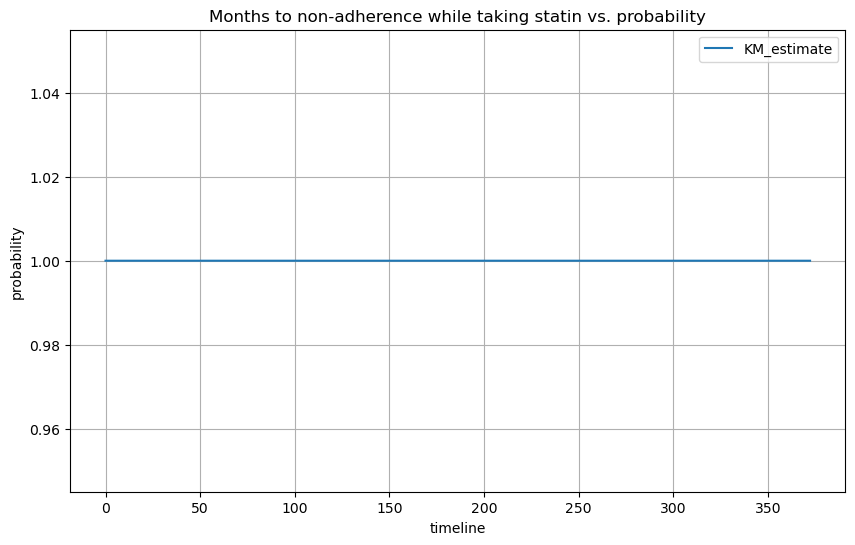

In [28]:
kmf = KaplanMeierFitter()
T = hazard_df['rx_months']
C = hazard_df['rx_censor']
kmf.fit(T,C);

fig, ax = plt.subplots(figsize=(10,6));
plt.title('Months to non-adherence while taking statin vs. probability')
plt.ylabel('probability')
kmf.plot();
ax.grid();

###  Hazards calculated based on death rate

Shifted to calculating the censored event as death vs. non-adherence to further explore the data

In [29]:
#Calculate Duration Months and Flag Censored Data
rx_censor=[]
rx_months=[]

for i in range(len(hazard_df)):
    death = pd.to_datetime(hazard_df.death_date[i])
    laststop = pd.to_datetime(hazard_df.latest_stop[i])
    earlystart = pd.to_datetime(hazard_df.earliest_start[i])


    if str(death) != ('NaT'): #if patient hasn't died
        months = (death-earlystart).days / 30
        censor = 0
    
    else:  #when the patient has died
        if (laststop.year==2021) and (laststop.month==7) and (laststop.day==31): #if patient is still taking med
            months = (laststop-earlystart).days / 30
            censor = 1
        else: #if patient stopped med before 2021-07-31 and hasn't died
            months = (laststop-earlystart).days / 30
            censor = 0
    
    rx_censor.append(censor)
    rx_months.append(months)

#Append to dataframe
hazard_df['rx_censor'] = rx_censor
hazard_df['rx_months'] = rx_months


In [30]:
#Export for examination
#hazard_df.to_csv('hazard_df.csv')

### Kaplan Meier Curves - Time to Death

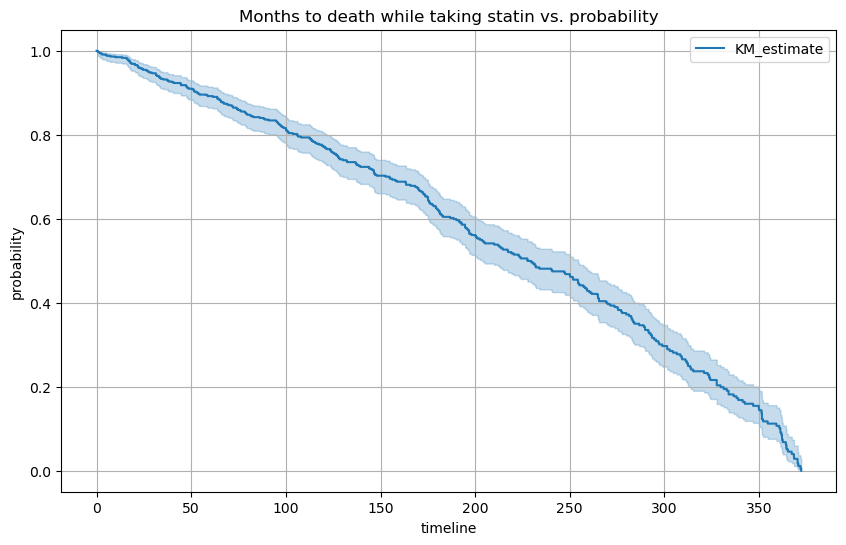

In [31]:
kmf = KaplanMeierFitter()
T = hazard_df['rx_months']
C = hazard_df['rx_censor']
kmf.fit(T,C);

fig, ax = plt.subplots(figsize=(10,6));
plt.title('Months to death while taking statin vs. probability')
plt.ylabel('probability')
kmf.plot();
ax.grid();

### Kaplan Meier Curves for Different Segments

Note that the data performs equally for men/women and white/non-white populations.   In real life situations this would not hold true.  

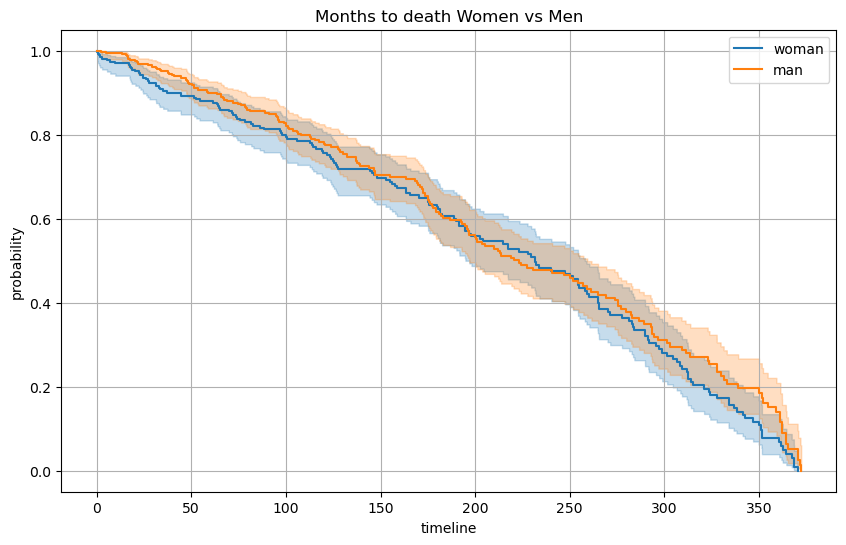

In [32]:
#Create separate dfs for married/unmarried
men_df = hazard_df[hazard_df.gender == 'M']
women_df =hazard_df[hazard_df.gender == 'F']

#Create separate models for married/unmarried
kmf_m = KaplanMeierFitter()
T_m = men_df.rx_months
C_m = men_df.rx_censor
kmf_m.fit(T_m,C_m);

kmf_w = KaplanMeierFitter()
T_w = women_df.rx_months
C_w = women_df.rx_censor
kmf_w.fit(T_w,C_w)

#Plot married and unmarried curve
fig, ax = plt.subplots(figsize=(10,6));
plt.title('Months to death Women vs Men')
plt.ylabel('probability')
kmf_w.plot(label='woman');
kmf_m.plot(label='man');
ax.grid();

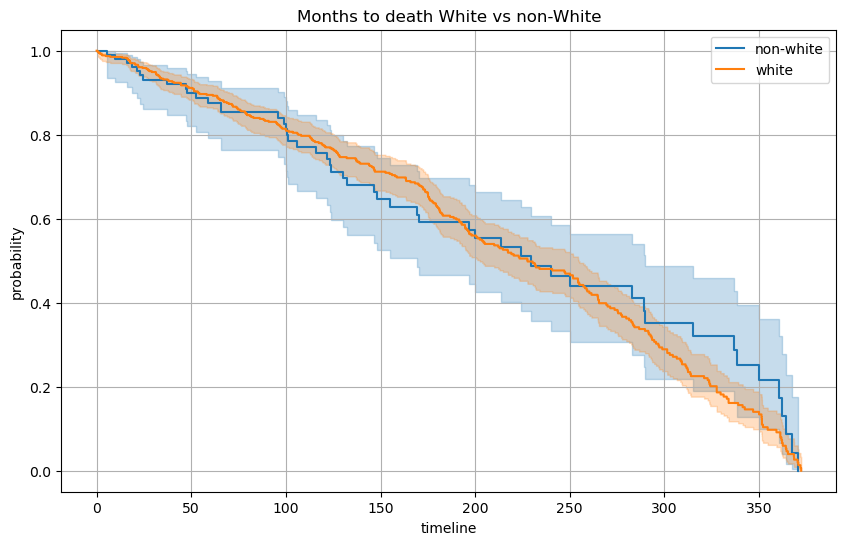

In [33]:
#Create separate dfs for married/unmarried
wh_df = hazard_df[hazard_df.race == 'white']
nonwh_df =hazard_df[hazard_df.race != 'white']

#Create separate models for married/unmarried
kmf_m = KaplanMeierFitter()
T_m = wh_df.rx_months
C_m = wh_df.rx_censor
kmf_m.fit(T_m,C_m);

kmf_w = KaplanMeierFitter()
T_w = nonwh_df.rx_months
C_w = nonwh_df.rx_censor
kmf_w.fit(T_w,C_w)

#Plot married and unmarried curve
fig, ax = plt.subplots(figsize=(10,6));
plt.title('Months to death White vs non-White')
plt.ylabel('probability')
kmf_w.plot(label='non-white');
kmf_m.plot(label='white');
ax.grid();

### Cox Proportional Hazards

In conducting a Cox-Proportional Hazards analysis on the data we see that only 'age at start' is statistically significant.  Race and gender drop out as statistically insignficant.   Plotting the proportional hazards for different age bands, we see that starting statins at a younger age yields higher survival curves than curves for those who started statins at a later age.   Since this is synthetic data and not observational, we can't conclude this in real life, however, this does seem like a good, practical behavior for the synthetic data set to mimic.

In [34]:
#Modify data frame to be numeric

#Create new version of df for this problem
df_2 = hazard_df.loc[:,['rx_censor','rx_months','gender','race','age_at_start']]

df_2.gender = [1 if i=='M' else 0 for i in df_2.gender]
df_2.race = [1 if i=='white' else 0 for i in df_2.race]

df_2

,rx_censor,rx_months,gender,race,age_at_start
0,1,79.066667,1,1,56.0
1,1,190.066667,0,1,44.0
2,0,35.466667,1,1,50.0
3,0,74.333333,1,1,77.0
4,1,94.766667,1,1,48.0
...,...,...,...,...,...
655,0,122.966667,1,1,61.0
656,0,101.200000,1,1,76.0
657,0,312.533333,1,1,61.0
658,0,62.300000,1,1,70.0


In [35]:
#Create new version of df for this problem
#df_2 = hazard_df.loc[:,['rx_censor','rx_months','gender','race','age_at_start']]

#count number of features to iterate (subtract duration/event cols)
feat_num = len(df_2.columns) - 2

for i in range(feat_num):
    #instantiate a model
    cph = CoxPHFitter()
    cph.fit(df_2, duration_col='rx_months', event_col='rx_censor')

    #create a dataframe with summary 
    cph_df = cph.summary

    #check to see if no coef are >0.05, and if so pass
    if len(cph_df[cph_df.p>0.05]) == 0:
        pass 
    #check to see what the highest p-value is and drop that coef's column from dataframe
    else:
        sort = cph_df.p.sort_values(ascending=False)
        drop_column = sort.index[0]
        #drop column from data frame
        df_2.drop(drop_column,axis=1, inplace=True)

#Print resulting model summary:
cph_df

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
age_at_start,0.014755,1.014864,0.003899,0.007112,0.022397,1.007137,1.02265,0.0,3.7838,0.000154,12.660556


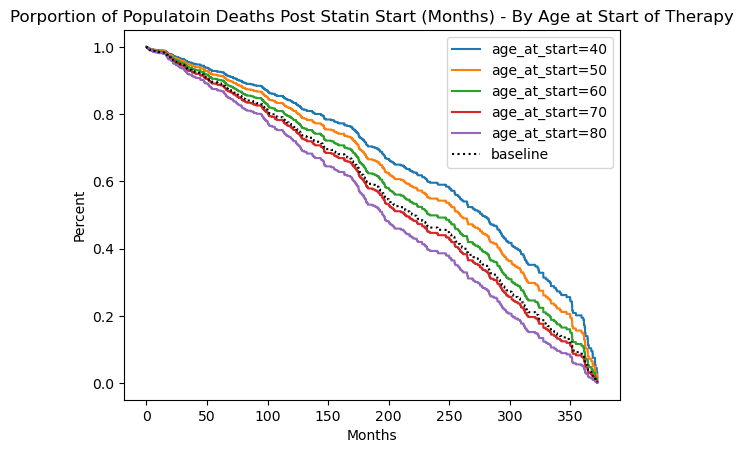

In [36]:
cph.plot_partial_effects_on_outcome(covariates=['age_at_start'],values= np.arange(40, 90, 10))
plt.title('Porportion of Populatoin Deaths Post Statin Start (Months) - By Age at Start of Therapy')
plt.xlabel('Months')
plt.ylabel('Percent');

### Conclusion

While I'd hoped to conduct advanced adeherence analytics techniques on this data, it is not structured to support adherence analytics so this won't be possible.  That said, key finding from the study show areas for improvement of the Synthea data set:   1) Inclusion of additional product types: seems to be limited to generic pharmaceuticals and excludes several modern treatment categories treated with branded drugs with patent protection   2) Looking at launch days of key product classes to ensure that patient use of the medicine makes sense  3) Implement data quality guidelines: medication data did not include dispense data for patients, yielding a large number of patients excluded from the study.  4) Implement behavior of non-adherence and compliance that is more realistic:  It is common for 

## Predicting Death

In [37]:
# ### REFERENCES

# **General**
# 
#  https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/
# 
# **Random Forrest**
#  https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.ensemble.RandomSurvivalForest.html
# 
#  https://square.github.io/pysurvival/models/random_survival_forest.html
# 
#  https://notebook.community/sebp/scikit-survival/examples/00-introduction
# 
# **Evaluating Survival Models**
#  https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html
#  
#  https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.metrics.integrated_brier_score.html
#  
#  https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.metrics.concordance_index_censored.html

### Package Imports

In [38]:
# Install packages
# pip install scikit-survival
# pip install random-survival-forest


In [39]:

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import integrated_brier_score


rstate = 82


In [40]:
#https://github.com/sebp/scikit-survival/blob/master/sksurv/datasets/base.py

def _get_x_y_survival(dataset, col_event, col_time, val_outcome):
    if col_event is None or col_time is None:
        y = None
        x_frame = dataset
    else:
        y = np.empty(dtype=[(col_event, bool), (col_time, np.float64)], shape=dataset.shape[0])
        y[col_event] = (dataset[col_event] == val_outcome).values
        y[col_time] = dataset[col_time].values

        x_frame = dataset.drop([col_event, col_time], axis=1)

    return x_frame, y


In [41]:
hazard_df.head()

,patient_ID,earliest_start,latest_start,latest_stop,death_date,age_at_start,dispense_count,simv_10_count,simv_20_count,atorv_80_count,last_disp_amt,gender,race,rx_censor,rx_months
0,b24e154c-14c4-8372-2b52-a466bc9b44fe,2015-02-01,2021-01-30,2021-07-31,NaN,56.0,82,82,0,0,12,M,white,1,79.066667
1,fd263d8e-7d79-e54c-0c5f-351a1e3635ed,2005-12-20,2020-12-16,2021-07-31,NaN,44.0,190,190,0,0,12,F,white,1,190.066667
2,40c7c5d7-e21d-0aec-3023-bf613f37a5f1,1995-06-02,1997-06-01,1998-05-01,1998-05-01,50.0,34,34,0,0,12,M,white,0,35.466667
3,b6d9f9f6-b4b0-8b31-1827-dcc141011135,1994-05-20,2000-06-23,2000-06-27,2000-06-27,77.0,74,0,74,0,1,M,white,0,74.333333
4,5450a2c7-c50c-ac32-81fe-425e52b21c52,2013-10-18,2020-10-16,2021-07-31,NaN,48.0,94,94,0,0,12,M,white,1,94.766667


### Prepare Data

In [42]:
cox_new_df = hazard_df.copy()


#Get dummies/One Hot Encode categorical variables
ohe_cols = ['race','gender']
cox_new_df = pd.get_dummies(cox_new_df, columns = ohe_cols) 

#change type of the get dummies variables to int
cox_new_df.iloc[:,16:25]= cox_new_df.iloc[:,16:25].astype(int)

#drop patient id field
cox_new_df = cox_new_df.drop(['patient_ID'],axis=1)
cox_new_df = cox_new_df.drop(['earliest_start'],axis=1)
cox_new_df = cox_new_df.drop(['latest_start'],axis=1)
cox_new_df = cox_new_df.drop(['latest_stop'],axis=1)
cox_new_df = cox_new_df.drop(['death_date'],axis=1)

#drop NAs
cox_new_df = cox_new_df.dropna()

#Format as int
cox_new_df = cox_new_df.astype(int)

In [43]:
#Information on variables used in model
cox_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age_at_start    660 non-null    int32
 1   dispense_count  660 non-null    int32
 2   simv_10_count   660 non-null    int32
 3   simv_20_count   660 non-null    int32
 4   atorv_80_count  660 non-null    int32
 5   last_disp_amt   660 non-null    int32
 6   rx_censor       660 non-null    int32
 7   rx_months       660 non-null    int32
 8   race_asian      660 non-null    int32
 9   race_black      660 non-null    int32
 10  race_native     660 non-null    int32
 11  race_white      660 non-null    int32
 12  gender_F        660 non-null    int32
 13  gender_M        660 non-null    int32
dtypes: int32(14)
memory usage: 36.2 KB


In [44]:
# Split the data into train/test subsets
X, y = _get_x_y_survival(cox_new_df, 'rx_censor', 'rx_months', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rstate)

#Save indices
train_index = X_train.index.tolist()
test_index = X_test.index.tolist()


### CPH Prediction

In [45]:
# Fit curves
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

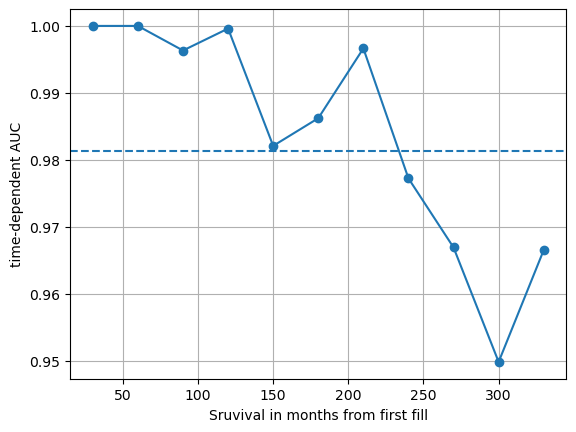

In [46]:
times = np.arange(30, 350, 30)
cph_risk_scores = cph.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

plt.plot(times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Sruvival in months from first fill")
plt.ylabel("time-dependent AUC")
plt.grid(True)


In [47]:
cph_ci = cph.score(X_test, y_test)
print("C-index", cph_ci)

C-index 0.9609763447340666


### Random Forest Prediction

In [48]:
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=7,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=rstate,
                           verbose=1)

rsf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.2s finished


RandomSurvivalForest(min_samples_leaf=10, min_samples_split=7, n_estimators=50,
                     n_jobs=-1, random_state=82, verbose=1)

In [49]:
y_pred = rsf.predict(X_test)

rsf_ci = rsf.score(X_test, y_test)
print("C-index", rsf_ci)


C-index 0.9000301340967305


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


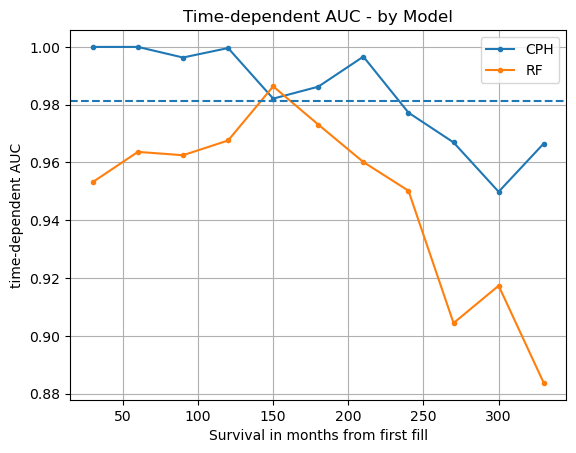

In [50]:
#### Plot of Time Dependent AUC
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)
rf_auc, rf_mean_auc = cumulative_dynamic_auc(y_train, y_test, y_pred, times)

plt.plot(times, cph_auc, marker=".",label='CPH')
plt.plot(times, rf_auc, marker=".",label='RF')
plt.axhline(cph_mean_auc, linestyle="--")
plt.title("Time-dependent AUC - by Model")
plt.xlabel("Survival in months from first fill")
plt.ylabel("time-dependent AUC")
plt.legend()
plt.grid(True)


## Gradient Boost Prediction

In [51]:
# ### References:
# **Boosting**https://scikit-survival.readthedocs.io/en/stable/user_guide/boosting.html
# 
# 
# **XGBSE** ** Not used but for future reference**
# https://towardsdatascience.com/xgbse-improving-xgboost-for-survival-analysis-393d47f1384a

# In[51]:


from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis


In [52]:
gb_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=rstate)
gb_cph_tree.fit(X_train, y_train)
ci_gb = gb_cph_tree.score(X_test, y_test)
print('C-Index: ',ci_gb)

C-Index:  0.9674551755311135


In [53]:
concordance_df = pd.DataFrame({"Model": ['CPH','Random Forest','GB'], "C-index": [cph_ci,rsf_ci,ci_gb]})
concordance_df

,Model,C-index
0,CPH,0.960976
1,Random Forest,0.900030
2,GB,0.967455


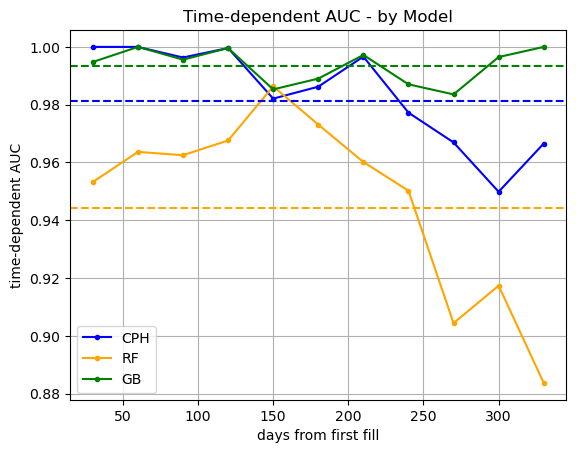

In [54]:

#### Plot of Time Dependent AUC
gb_pred = gb_cph_tree.predict(X_test)
gb_auc, gb_mean_auc = cumulative_dynamic_auc(y_train, y_test, gb_pred, times)

plt.plot(times, cph_auc, marker=".",label='CPH',color='blue')
plt.plot(times, rf_auc, marker=".",label='RF',color='orange')
plt.plot(times, gb_auc, marker=".",label='GB',color='green')
plt.axhline(cph_mean_auc, linestyle="--",color='blue')
plt.axhline(rf_mean_auc, linestyle="--",color='orange')
plt.axhline(gb_mean_auc, linestyle="--",color='green')
plt.title("Time-dependent AUC - by Model")
plt.xlabel("days from first fill")
plt.ylabel("time-dependent AUC")
plt.legend()
plt.grid(True)


### Integrated Brier Score
 

In [55]:


rsf_surv_prob = np.row_stack([fn(times) for fn in rsf.predict_survival_function(X_test)])
cph_surv_prob = np.row_stack([fn(times) for fn in cph.predict_survival_function(X_test)])
gb_surv_prob = np.row_stack([fn(times) for fn in gb_cph_tree.predict_survival_function(X_test)])


score_brier = pd.Series(
    [
        integrated_brier_score(y, y_test, prob, times)
        for prob in (rsf_surv_prob, cph_surv_prob,gb_surv_prob)
    ],
    index=[0,1,2],
    name="IBS",
)

pd.concat((concordance_df, score_brier), axis=1).round(3)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


,Model,C-index,IBS
0,CPH,0.961,0.065
1,Random Forest,0.900,0.310
2,GB,0.967,0.062
